# Result Comparison  -Encodders

Here the following encodders will be evaluated with their generations in test:
- bte-en-1.5-base
- contriever
- gte

The evaluation will be through the Rouge-L, Accuracy and appearence of the gold document

In [7]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import os



## Data Loading

In [8]:
#### Load generation results
previews = {
    "0": "power_of_noise_prompt",
    "1": "new_prompt",
    "2": "prompt_optional_retrieve"
}

dfs = []

for f in os.listdir("previews_results"):

    _preview_num = f.split("_")[1]


    if f.endswith("datamodels.feather"):
        retrieval = "datamodels"
        type = previews[_preview_num]

    elif f.endswith("baseline.feather"):
        retrieval = "baseline"
        type = "baseline"

    else:
        retrieval = "rag"
        type = previews[_preview_num]


    

    _df = pl.read_ipc(f"previews_results/{f}")
    _df = _df.with_columns(pl.lit(retrieval).alias("retrieval"))
    _df = _df.with_columns(pl.lit(type).alias("type"))
    dfs.append(_df)

### Compute baseline

df = pl.concat(dfs)
df


idx,mean,max,metric,retrieval,type
i64,f64,f64,str,str,str
0,0.0,0.0,"""rouge_l""","""baseline""","""baseline"""
1,1.0,1.0,"""rouge_l""","""baseline""","""baseline"""
2,0.0,0.0,"""rouge_l""","""baseline""","""baseline"""
3,1.0,1.0,"""rouge_l""","""baseline""","""baseline"""
4,0.8,1.0,"""rouge_l""","""baseline""","""baseline"""
…,…,…,…,…,…
45,0.0,0.0,"""squad_v2_best_exact""","""rag""","""power_of_noise_prompt"""
46,0.0,0.0,"""squad_v2_best_exact""","""rag""","""power_of_noise_prompt"""
47,0.2,1.0,"""squad_v2_best_exact""","""rag""","""power_of_noise_prompt"""


## 1. Plot Mean Metrics by Type Results

/tmp/ipykernel_432041/2718205769.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


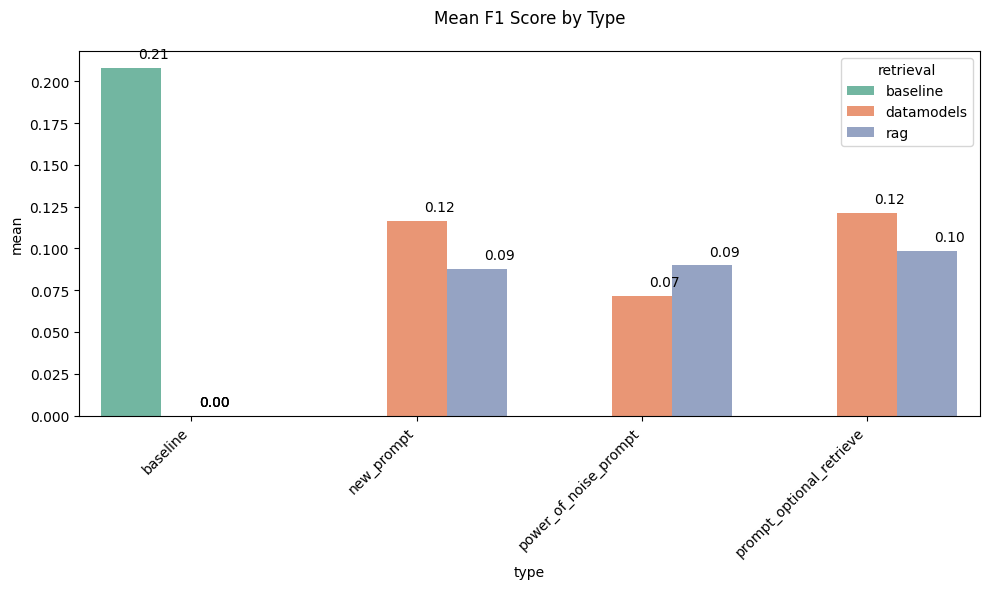

In [9]:
_agg_f1 = (
    df
    .filter(pl.col("metric") == "squad_v2_best_f1")
    .group_by(["retrieval", "type"])
    .agg(pl.col("mean").mean())
    .sort("type", "retrieval")
)
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=_agg_f1,
    x="type",
    y="mean",
    hue="retrieval",
    palette="Set2",
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2f}',  # Format the value (1 decimal place)
        (p.get_x() + 0.1 + p.get_width() / 2., p.get_height()),  # Position (x, y)
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
        xytext=(0, 10),  # Offset from the position
        textcoords='offset points'  # Coordinate system for the offset
    )


plt.title("Mean F1 Score by Type", pad=20)
plt.tight_layout()
plt.show()


/tmp/ipykernel_432041/3503798137.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


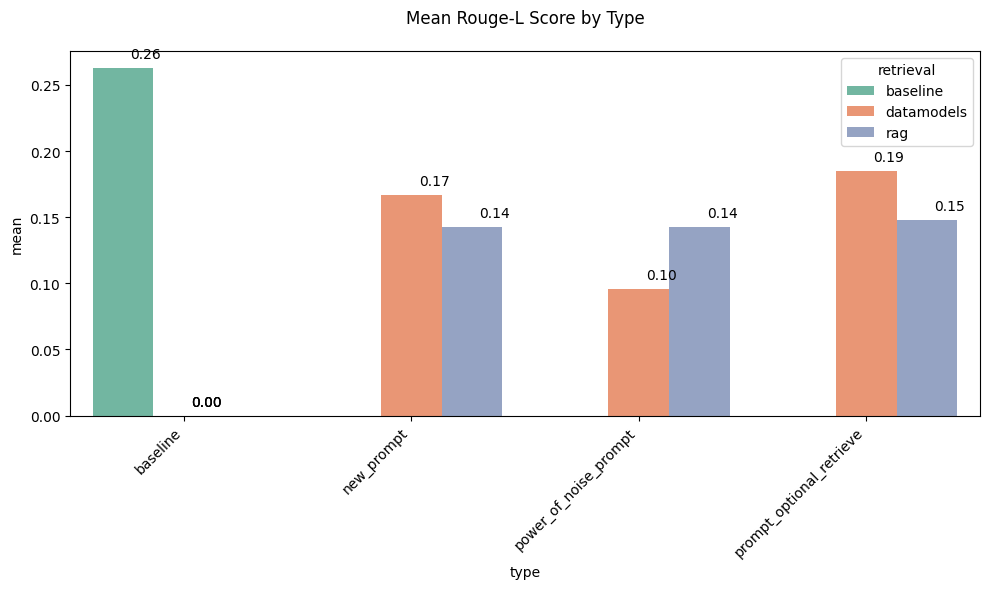

In [10]:
_agg_rouge = (
    df
    .filter(pl.col("metric") == "rouge_l")
    .group_by(["retrieval", "type"])
    .agg(pl.col("mean",).mean())
    .sort("type", "retrieval")
)
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=_agg_rouge,
    x="type",
    y="mean",
    hue="retrieval",
    palette="Set2",
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2f}',  # Format the value (1 decimal place)
        (p.get_x() + 0.1 + p.get_width() / 2., p.get_height()),  # Position (x, y)
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
        xytext=(0, 10),  # Offset from the position
        textcoords='offset points'  # Coordinate system for the offset
    )


plt.title("Mean Rouge-L Score by Type", pad=20)
plt.tight_layout()
plt.show()

## Ivnestigate the recall for each metric for the best generations (IP and baseline)

/tmp/ipykernel_432041/573040930.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


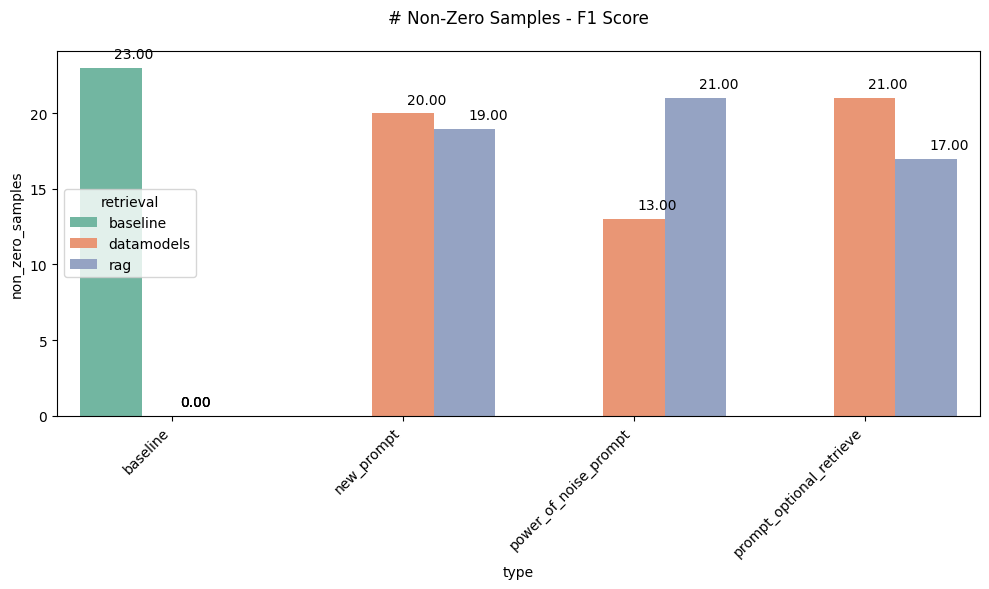

In [11]:
_non_zero_f1 = (
    df
    .filter(pl.col("metric") == "squad_v2_best_f1")
    .group_by(["retrieval", "type", "idx"])
    .agg(pl.col("mean").mean())
    .sort("type", "retrieval")
    .filter(pl.col("mean") > 0)
    .group_by(["retrieval", "type"])
    .agg(pl.col("mean").count().alias("non_zero_samples"))
    .sort("type", "retrieval")
)
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=_non_zero_f1,
    x="type",
    y="non_zero_samples",
    hue="retrieval",
    palette="Set2",
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2f}',  # Format the value (1 decimal place)
        (p.get_x() + 0.1 + p.get_width() / 2., p.get_height()),  # Position (x, y)
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
        xytext=(0, 10),  # Offset from the position
        textcoords='offset points'  # Coordinate system for the offset
    )


plt.title("# Non-Zero Samples - F1 Score", pad=20)
plt.tight_layout()
plt.show()

/tmp/ipykernel_432041/4252575034.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


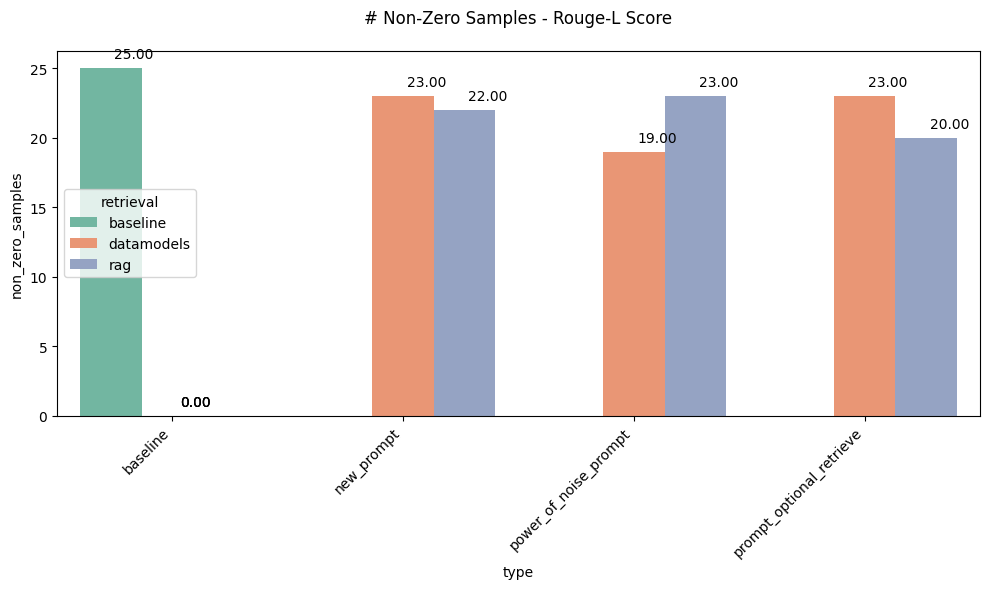

In [12]:
_non_zero_rouge = (
    df
    .filter(pl.col("metric") == "rouge_l")
    .group_by(["retrieval", "type", "idx"])
    .agg(pl.col("mean").mean())
    .sort("type", "retrieval")
    .filter(pl.col("mean") > 0)
    .group_by(["retrieval", "type"])
    .agg(pl.col("mean").count().alias("non_zero_samples"))
    .sort("type", "retrieval")
)
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=_non_zero_rouge,
    x="type",
    y="non_zero_samples",
    hue="retrieval",
    palette="Set2",
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2f}',  # Format the value (1 decimal place)
        (p.get_x() + 0.1 + p.get_width() / 2., p.get_height()),  # Position (x, y)
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
        xytext=(0, 10),  # Offset from the position
        textcoords='offset points'  # Coordinate system for the offset
    )


plt.title("# Non-Zero Samples - Rouge-L Score", pad=20)
plt.tight_layout()
plt.show()